# CFD LMS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pydaptivefiltering as pdf

CFDLMS Adaptation completed in 11.512 ms


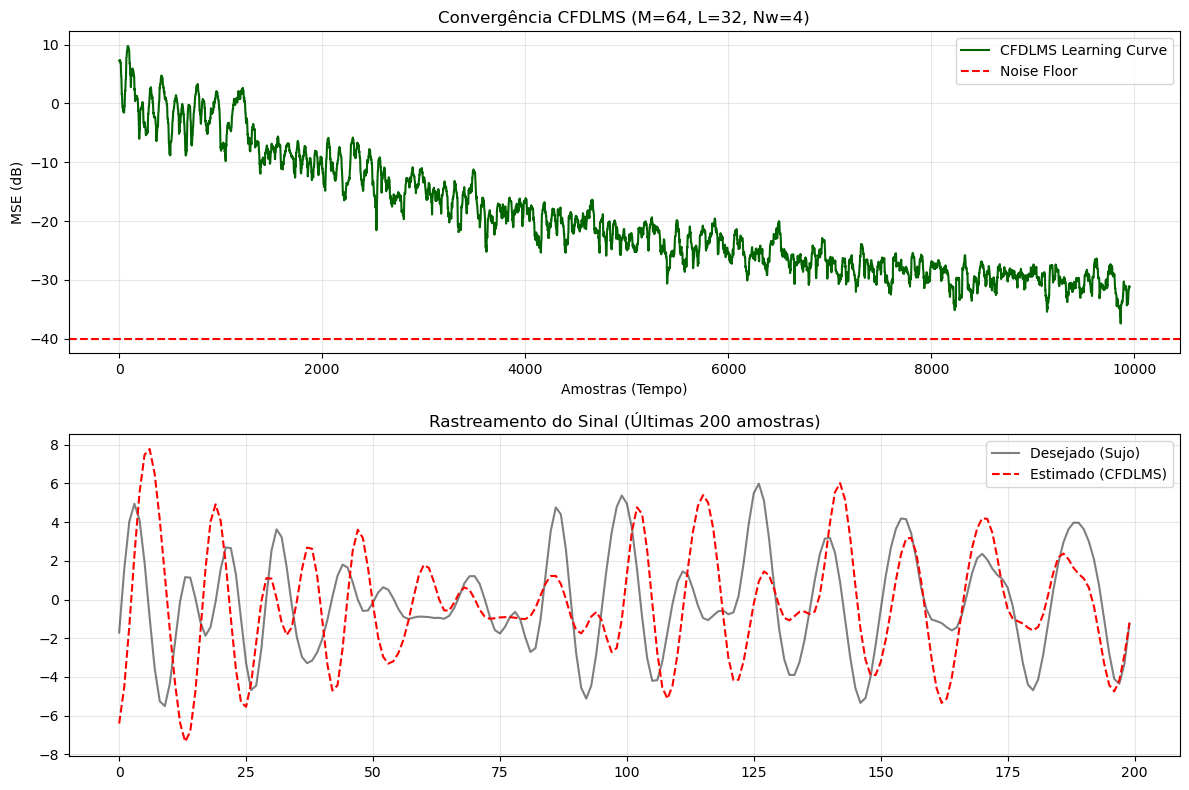

MSE Final (Regime Permanente): 9.405674e-04


In [3]:
# --- 1. Geração de Sinais (Sinal Colorido para Desafiar o Filtro) ---
def generate_data(n_samples=10000, noise_std=0.01):
    rng = np.random.default_rng(42)
    
    # Criando um sinal de entrada colorido (Processo AR)
    # Sinais correlacionados degradam o LMS, mas o CFDLMS lida bem via FFT
    b_ar, a_ar = signal.butter(4, 0.2)
    x = signal.lfilter(b_ar, a_ar, rng.standard_normal(n_samples))
    x /= np.std(x) # Normalização
    
    # Sistema Desconhecido (Planta) - Filtro FIR de 32 coeficientes
    # Vamos criar uma resposta ao impulso com decaimento
    h_unknown = np.exp(-0.1 * np.arange(32)) * np.cos(0.5 * np.arange(32))
    
    # Sinal Desejado com Ruído
    d = np.convolve(x, h_unknown, mode='full')[:n_samples]
    d += noise_std * rng.standard_normal(n_samples)
    
    return x, d, h_unknown

x, d, h_true = generate_data()

# --- 2. Configuração do CFDLMS ---
# M: Número de sub-bandas (bins de frequência)
# L: Hop size (salto). Geralmente M/2
# Nw: Ordem do filtro em cada bin (Nw+1 taps)
M = 64
L = 32
Nw = 4 # O filtro total equivalente tem cerca de (Nw+1)*L taps

model = pdf.CFDLMS(
    filter_order=Nw, 
    n_subbands=M, 
    decimation=L, 
    step=0.2, 
    smoothing=0.1,
    gamma=1e-3
)

# --- 3. Execução ---
res = model.optimize(x, d, verbose=True)

y = res['outputs']
e = res['errors']

# --- 4. Análise de Resultados ---

# Cálculo do MSE em dB (suavizado)
mse_db = 10 * np.log10(np.convolve(e**2, np.ones(L)/L, mode='valid') + 1e-12)

plt.figure(figsize=(12, 8))

# Gráfico 1: Curva de Aprendizado
plt.subplot(2, 1, 1)
plt.plot(mse_db, color='darkgreen', label='CFDLMS Learning Curve')
plt.axhline(10*np.log10(0.01**2), color='red', linestyle='--', label='Noise Floor')
plt.title(f"Convergência CFDLMS (M={M}, L={L}, Nw={Nw})")
plt.ylabel("MSE (dB)")
plt.xlabel("Amostras (Tempo)")
plt.grid(True, alpha=0.3)
plt.legend()

# Gráfico 2: Rastreamento do Sinal (Final do sinal)
plt.subplot(2, 1, 2)
plt.plot(d[-200:], 'k', alpha=0.5, label='Desejado (Sujo)')
plt.plot(y[-200:], 'r--', label='Estimado (CFDLMS)')
plt.title("Rastreamento do Sinal (Últimas 200 amostras)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"MSE Final (Regime Permanente): {np.mean(e[-500:]**2):.6e}")